In [1]:
import numpy as np
import win32gui
import win32ui
import win32con
import cv2 as cv
import numpy as np
import os
from time import time
import pygetwindow
from PIL import Image
import pyautogui

# Getting the List of Availble Windows

In [ ]:
# Getting Window names
def winEnumHandler(hwnd, ctx):
    if win32gui.IsWindowVisible(hwnd):
        print(hex(hwnd), win32gui.GetWindowText(hwnd))

win32gui.EnumWindows(winEnumHandler, None)

In [ ]:
# def callback(hwnd, extra):
#     rect = win32gui.GetWindowRect(hwnd)
#     x = rect[0]
#     y = rect[1]
#     w = rect[2] - x
#     h = rect[3] - y
#     print("Window %s:" % win32gui.GetWindowText(hwnd))
#     print("\tLocation: (%d, %d)" % (x, y))
#     print("\t    Size: (%d, %d)" % (w, h))
    
# win32gui.EnumWindows(callback, None)

# x2 = x + w # 1529 + 155-
# y2 = y + h # -7 + 838
# Drawing Rectangle.
x1 = 350 # Origin at top left of screen
y1 = 400 # # Origin at top left of screen
x2 = 1550
y2 = 800 
path = 'test.png'
pyautogui.screenshot(path)
im = Image.open(path)
im  = im.crop((x1,y1,x2,y2))
im.save(path)
im.show(path)

# Window Capture Class

In [ ]:
import numpy as np
import win32gui
import win32ui
import win32con


class WindowCapture:

    # properties
    w = 0
    h = 0
    hwnd = None
    cropped_x = 10000
    cropped_y = 10000
    offset_x = 0
    offset_y = 0

    # constructor
    def __init__(self, window_name):
        # find the handle for the window we want to capture
        self.hwnd = win32gui.FindWindow(None, window_name)
        if not self.hwnd:
            raise Exception('Window not found: {}'.format(window_name))

        # get the window size
        window_rect = win32gui.GetWindowRect(self.hwnd)  # Left, Top, Right, Bottom
        self.w = window_rect[2] - window_rect[0]  # Width = Right - Left
        self.h = window_rect[3] - window_rect[1]  # Height = Bottom - Top

        # account for the window border and titlebar and cut them off
        border_pixels = 100
        titlebar_pixels = 450  # Manages the y axis crop.
        self.w = self.w - border_pixels
        self.h = self.h - titlebar_pixels - border_pixels
        self.cropped_x = border_pixels
        self.cropped_y = titlebar_pixels

        # set the cropped coordinates offset so we can translate screenshot
        # images into actual screen positions
        self.offset_x = window_rect[0] + self.cropped_x
        self.offset_y = window_rect[1] + self.cropped_y

    def get_screenshot(self):
        # get the window image data
        # wDC = win32gui.GetWindowDC(self.hwnd)
        hdesktop = win32gui.GetDesktopWindow()
        hwndDC = win32gui.GetWindowDC(hdesktop)
        dcObj = win32ui.CreateDCFromHandle(hwndDC)
        cDC = dcObj.CreateCompatibleDC()
        dataBitMap = win32ui.CreateBitmap()
        dataBitMap.CreateCompatibleBitmap(dcObj, self.w, self.h)
        cDC.SelectObject(dataBitMap)
        cDC.BitBlt((0, 0), (self.w, self.h), dcObj,
                   (self.cropped_x, self.cropped_y), win32con.SRCCOPY)

        # convert the raw data into a format opencv can read
        #dataBitMap.SaveBitmapFile(cDC, 'debug.bmp')
        signedIntsArray = dataBitMap.GetBitmapBits(True)
        img = np.fromstring(signedIntsArray, dtype='uint8')
        img.shape = (self.h, self.w, 4)

        # free resources
        dcObj.DeleteDC()
        cDC.DeleteDC()
        win32gui.ReleaseDC(self.hwnd, hwndDC)
        win32gui.DeleteObject(dataBitMap.GetHandle())

        # drop the alpha channel, or cv.matchTemplate() will throw an error like:
        #   error: (-215:Assertion failed) (depth == CV_8U || depth == CV_32F) && type == _templ.type()
        #   && _img.dims() <= 2 in function 'cv::matchTemplate'
        img = img[..., :3]

        # make image C_CONTIGUOUS to avoid errors that look like:
        #   File ... in draw_rectangles
        #   TypeError: an integer is required (got type tuple)
        # see the discussion here:
        # https://github.com/opencv/opencv/issues/14866#issuecomment-580207109
        img = np.ascontiguousarray(img)

        return img

    # find the name of the window you're interested in.
    # once you have it, update window_capture()
    # https://stackoverflow.com/questions/55547940/how-to-get-a-list-of-the-name-of-every-open-window
    def list_window_names(self):
        def winEnumHandler(hwnd, ctx):
            if win32gui.IsWindowVisible(hwnd):
                print(hex(hwnd), win32gui.GetWindowText(hwnd))
        win32gui.EnumWindows(winEnumHandler, None)

    # translate a pixel position on a screenshot image to a pixel position on the screen.
    # pos = (x, y)
    # WARNING: if you move the window being captured after execution is started, this will
    # return incorrect coordinates, because the window position is only calculated in
    # the __init__ constructor.
    def get_screen_position(self, pos):
        return (pos[0] + self.offset_x, pos[1] + self.offset_y)


# Main Class

In [ ]:
import cv2 as cv
import win32con as con
import numpy as np
import os
from time import time
from windowcapture import WindowCapture
from utils.getkeys import keys
# Change the working directory to the folder this script is in.
# Doing this because I'll be putting the files from each video in their own folder on GitHub
os.chdir(os.path.dirname(os.path.abspath(__file__)))

file_name = "Data/screenshots.npy"
file_name2 = "Data/command_keys.npy"


def get_data():
    '''Function obtained from ClarityCoders:
    https://github.com/ClarityCoders/Fall-Guys-AI/blob/master/CreateData.py'''
    if os.path.isfile(file_name):
        print('File exists, loading previous data!')
        image_data = list(np.load(file_name, allow_pickle=True))
        targets = list(np.load(file_name2, allow_pickle=True))
    else:
        print('File does not exist, starting fresh!')
        image_data = []
        targets = []
    return image_data, targets


def save_data(image_data, targets):
    '''Function obtained from ClarityCoders:
    https://github.com/ClarityCoders/Fall-Guys-AI/blob/master/CreateData.py'''
    np.save(file_name, image_data)
    np.save(file_name2, targets)


def main():
    '''Main function to execute.'''
    image_data, target = get_data()
    # initialize the WindowCapture class
    wincap = WindowCapture('T-Rex Game – Google Dino Run - Google Chrome')
    while True:
        print("Press 'Space' to start -- else 'q' to quit program")
        key = keys()
        if key == 'Q':  # quit
            cv.destroyAllWindows()
            break
        if key == 32:
            print("Starting Program")
            break
        elif key == con.VK_UP:
            print("You pressed the up arrow key...")
        elif key == con.VK_DOWN:
            print("You pressed the down arrow key...")

    loop_time = time()
    while(True):
        # get an updated image of the game
        screenshot = wincap.get_screenshot()
        #cv.imshow('Computer Vision', screenshot)
        # Storing the images.
        # debug the loop rate
        print('FPS {}'.format(1 / (time() - loop_time)))
        loop_time = time()
        key = keys()
        if key == "Q":
            cv.destroyAllWindows()
            break
        if key == con.VK_UP or key == 32:
            print("Up Arrow key or Space bar initiated")
            #screenshot = cv.resize(screenshot, (224, 224))
            image_data.append(screenshot)
            target.append(key)
        elif key == con.VK_DOWN:
            print("Down Arrow Key initiated")
            #screenshot = cv.resize(screenshot, (224, 224))
            image_data.append(screenshot)
            target.append(key)
    print('Done.')
    save_data(image_data, target)
    print("Finished saving image data with associated target values.")


if __name__ == '__main__':
    main()


# Let's take a look at an example image from the numpy array screenshot.

In [2]:
target_address = 'window_capture/Data/command_keys.npy'
targets = np.load(target_address)
targets.shape

(1155,)

In [150]:
targets

array([32, 32, 32, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
       38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
       38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
       38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 32, 32, 32, 32, 38, 38, 38,
       38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
       38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
       38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
       38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
       38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
       38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
       38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
       38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
       38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
       38, 38, 38, 38, 38

In [3]:
screenshot_address = 'window_capture/Data/screenshots.npy'
screenshot_data = np.load(screenshot_address)
screenshot_data.shape

(1155, 288, 1450, 3)

In [152]:
one_pic = screenshot_data[1]
one_pic.shape # Playing with the shapes

(288, 1450, 3)

In [153]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 10]

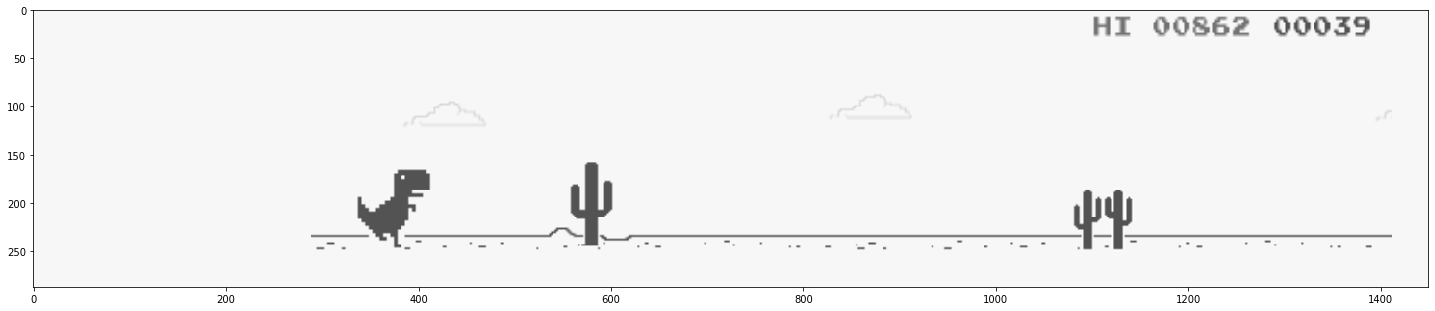

In [161]:
one_pic = screenshot_data[65] # looking at individual pictures.
plt.imshow(one_pic, interpolation='nearest')
plt.show()